# Исследование данных о пользователях сервиса аренды самокатов

В данной работе проанализированы данные о пользователях сервиса аренды самокатов.

**Используемые данные:**

- **users_go.csv**

    - `user_id`	уникальный идентификатор пользователя

    - `name`	имя пользователя

    - `age`	возраст

    - `city`	город

    - `subscription_type`	тип подписки (`free`, `ultra`)


- **rides_go.csv**
    - `user_id`	уникальный идентификатор пользователя

    - `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)

    - `duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

    - `date`	дата совершения поездки

- **subscriptions_go.csv**
    - `subscription_type`	тип подписки

    - `minute_price`	стоимость одной минуты поездки по данной подписке

    - `start_ride_price`	стоимость начала поездки

    - `subscription_fee`	стоимость ежемесячного платежа

**План работы:**
- Предобработка данных(преобразование типов, удаление дубликатов и аномалий, добавление полезных столбцов)

- Анализ следующих параметров:
    - частота встречаемости городов
    - соотношение пользователей с подпиской и без подписки
    - возраст пользователей
    - расстояние, которое пользователь преодолел за одну поездку
    - продолжительность поездок
- Агрегация данных, для дальнейшего анализа

- Подсчет выручки с каждого пользователя за каждый месяц с учетом типа подписки

- Проверка гипотез, нужных для сервиса

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

In [68]:
try:
    
    users = pd.read_csv('users_go.csv')
    rides = pd.read_csv('rides_go.csv')
    subscriptions = pd.read_csv('subscriptions_go.csv')
    
except:
    
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')    

Выведем общую информацию по таблицам

In [69]:
display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [70]:
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [71]:
display(subscriptions.head())
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    На первый взгляд данные хорошие, пропусков нет. Нужно сделать приведение типов object->datetime и object->category

#### Шаг 2. Предобработка данных

Изменим тип данных на datetime

In [72]:
rides.date = pd.to_datetime(rides.date,format='%Y-%m-%d')

так же изменим тип данных в колонках, содержащих тип тарифа на *category*

In [73]:
subscriptions['subscription_type'] = subscriptions['subscription_type'].astype('category')
users['subscription_type'] = users['subscription_type'].astype('category')

Проверим изменения

In [74]:
print(rides.info())
print(subscriptions.info())
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   subscription_type  2 non-null      category
 1   minute_price       2 non-null      int64   
 2   start_ride_price   2 non-null      int64   
 3   subscription_fee   2 non-null      int64   
dtypes: category(1), int64(3)
memory usage: 302.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data column

Добавим столбец с номером месяца

In [75]:
rides['month'] = rides.date.dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Посмотрим за какой промежуток времени данные

In [76]:
print(rides['date'].max())
print(rides['date'].min())

2021-12-30 00:00:00
2021-01-01 00:00:00


данные предоставлены за 2021 год

Проверим на наличие пропусков

In [77]:
users.isna().sum()
rides.isna().sum()
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверим на наличие дубликатов

In [78]:
print(users.duplicated().sum())
print(rides.duplicated().sum())

31
0


Уберем полные дубликаты из users

In [79]:
users = users.drop_duplicates()

In [80]:
users.duplicated().sum()

0

Проверим на неполные дубликаты таблицу rides. Таблицу users проверять не нужно, так как там вполне возможны дубликаты по имени, возрасту и городу

In [81]:
rides.duplicated(subset=['distance','duration','date']).sum()

0

 Посмотрим на наличие аномалий по параметрам age, duration и distance

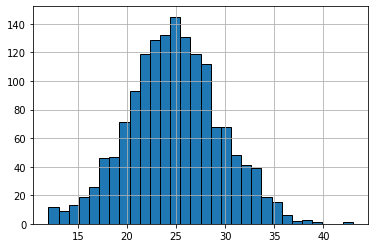

In [82]:
users['age'].hist(bins=30,edgecolor='black');

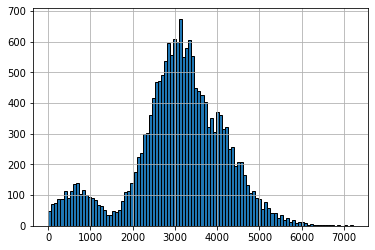

In [83]:
rides['distance'].hist(bins=100,edgecolor='black');

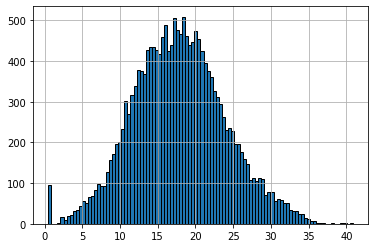

In [84]:
rides['duration'].hist(bins=100,edgecolor='black');

Посмотрим на аномалию около нуля в таблице rides в колонке duration

In [85]:
rides.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


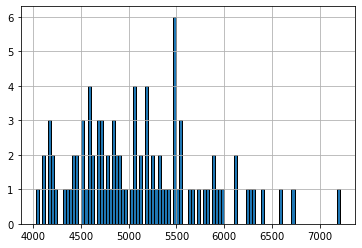

In [86]:
rides.query('duration < 2')['distance'].hist(bins=100,edgecolor='black');

Заметим, что те поездки, которые длились меньше 1 минуты, по расстоянию были более 4 км, такое невозможно.
Такое сложно объяснить, возможна ошибка при сборе данных или при загрузке.
Такие данные лучше удалить

In [87]:
rides = rides.query('duration >= 2').copy()

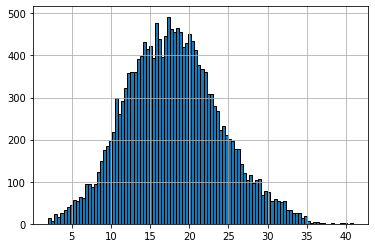

In [88]:
rides['duration'].hist(bins=100,edgecolor='black');

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    1) Были преобразованы типы колонки date в таблице rides к типу datetime и тип данных колонок subscription_type к category
    2) Был добавлен столбец союержащий номер месяца в таблицу rides
    3) Были убраны полные дубликаты из таблицы users
    4) Удалены аномалии из таблицы rides

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

количество пользователей по городам

In [89]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [90]:
users['city'].value_counts().describe()

count      8.000000
mean     191.750000
std       15.672998
min      168.000000
25%      182.250000
50%      191.000000
75%      199.500000
max      219.000000
Name: city, dtype: float64

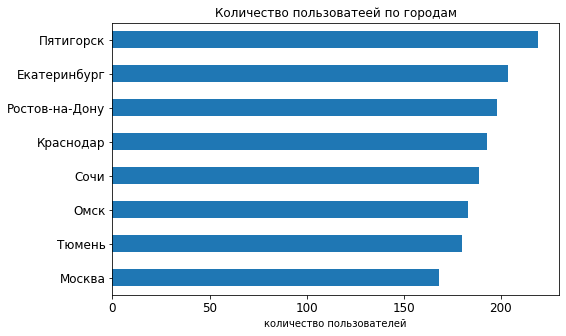

In [91]:
ax = users['city'].value_counts().sort_values().plot(kind='barh', figsize=(8, 5), fontsize=12)
ax.set_title('Количество пользоватеей по городам');
ax.set_xlabel('количество пользователей');

- среднее количество 192

- минимальное 168

- максимальное 219

Официальные данные о населении городов:

- Пятигорск - 146 267 

- Екатеринбург - 1 588 665

- Ростов-на-Дону - 1 142 162

- Краснодар - 1 099 344

- Сочи - 466 078

- Омск - 1 125 655 

- Тюмень - 855 618

- Москва - 12 655 050

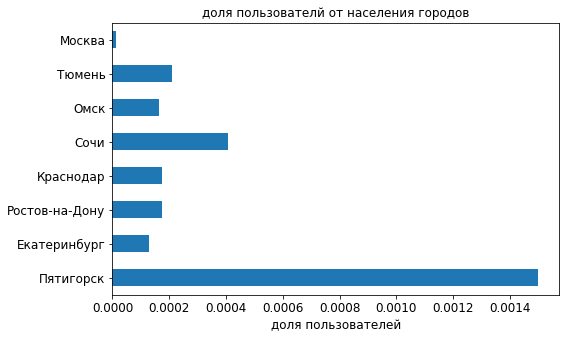

In [92]:
population = [146267, 1588665, 1142162, 1099344, 466078, 1125655, 855618, 12655050]
popularity = users['city'].value_counts().to_frame()
popularity['population'] = population
popularity['city'] = popularity['city']/popularity['population']
ax = popularity['city'].plot(kind='barh', figsize=(8, 5), fontsize=12)
ax.set_title('доля пользователй от населения городов');
ax.set_xlabel('доля пользователей', fontsize=12);

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Количество пользователей по городам примерно одинаковое, но учитывая население городов, можно заметить, что в Пятигорске 
    сервисом пользуется ибольший процент жителей, а в мск - меньший



 ##### Соотношение пользователей с подпиской и без

In [93]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

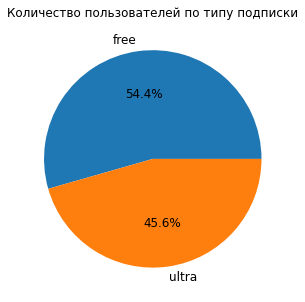

In [94]:
ax = users['subscription_type'].value_counts().plot(kind='pie', figsize=(5, 5), fontsize=12,rot=0,autopct='%1.1f%%');
ax.set_title('Количество пользователей по типу подписки', fontsize=12);
ax.set_ylabel('');

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Пользователей без подписки больше, но их количество различается не сильно
    
    - ultra 699 (45.6%)
    
    - free 835 (54.4%)
 

#### возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


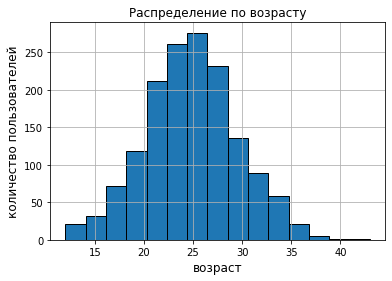

In [95]:
print(users['age'].describe())
ax = users['age'].hist(bins=15,edgecolor='black');
ax.set_title('Распределение по возрасту');
ax.set_ylabel('количество пользователей', fontsize=12);
ax.set_xlabel('возраст', fontsize=12);

In [96]:
print('Процент пользователей возрастом 20-30 лет: ',
      round(users.query('age <= 30 and age >= 20').shape[0]/users.shape[0]*100),'%', sep='')

Процент пользователей возрастом 20-30 лет: 77%


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Средний возраст пользователей - 25 лет
    Процент пользователей возрастом 20-30 лет: 77%
 

##### Расстояние, которое пользователь преодолел за одну поездку

In [97]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64


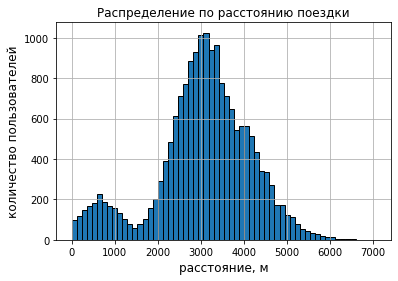

In [98]:
print(rides['distance'].describe())
ax = rides['distance'].hist(bins=60,edgecolor='black');
ax.set_title('Распределение по расстоянию поездки');
ax.set_ylabel('количество пользователей', fontsize=12);
ax.set_xlabel('расстояние, м', fontsize=12);

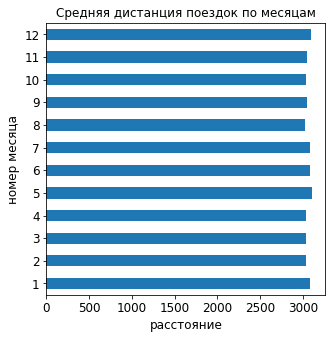

In [99]:
ax = rides.groupby('month')['distance'].mean().plot(kind='barh', figsize=(5, 5), fontsize=12,rot=0);
ax.set_title('Средняя дистанция поездок по месяцам');
ax.set_xlabel('расстояние', fontsize=12);
ax.set_ylabel('номер месяца', fontsize=12);

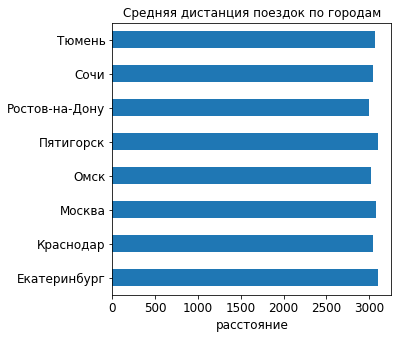

In [100]:
ax = (users.merge(rides, on='user_id')
      .groupby('city')['distance'].mean()
      .plot(kind='barh', figsize=(5, 5), fontsize=12,rot=0)
     )
ax.set_title('Средняя дистанция поездок по городам');
ax.set_xlabel('расстояние', fontsize=12);
ax.set_ylabel('');

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Среднее растояние за поездку - 3060 м.
    
    Однако стоит отметить небольшое увеличение количества поездок на расстоянии 0-1000 метров. Скорее всего это вызвано несколькими причинами, например - люди хотят опробовать новый вид транспорта, потому совершают первые поездки, чтобы просто покататься, а не добраться из А в Б.
    Так же странно, что средняя дистанция поездок почти не зависит от времени года и города.

#### Продолжительность поездок

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64


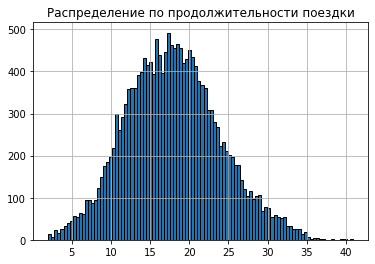

In [101]:
print(rides['duration'].describe())
rides['duration'].hist(bins=100,edgecolor='black');
plt.title('Распределение по продолжительности поездки');

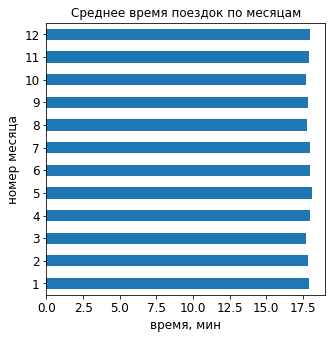

In [102]:
ax = rides.groupby('month')['duration'].mean().plot(kind='barh', figsize=(5, 5), fontsize=12,rot=0);
ax.set_title('Среднее время поездок по месяцам');
ax.set_xlabel('время, мин', fontsize=12);
ax.set_ylabel('номер месяца', fontsize=12);

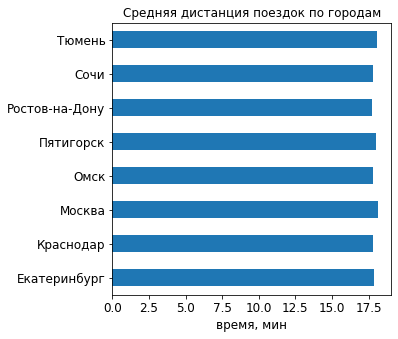

In [103]:
ax = (users.merge(rides, on='user_id')
      .groupby('city')['duration'].mean()
      .plot(kind='barh', figsize=(5, 5), fontsize=12,rot=0)
     )
ax.set_title('Средняя дистанция поездок по городам');
ax.set_xlabel('время, мин', fontsize=12);
ax.set_ylabel('');

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Среднее время за поездку - 18 мин.
    Среднее время так же не зависит от времени года и города

#### Шаг 4. Объединение данных

In [104]:
merged_data = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
merged_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Проверим на количество записей

In [105]:
rides.shape

(17973, 5)

In [106]:
merged_data.shape

(17973, 12)

Создаем две новых таблицы - пользователи с подпиской(ultra) и без(free)

In [107]:
ultra_subs = merged_data[merged_data['subscription_type'] == 'ultra']
free_subs = merged_data[merged_data['subscription_type'] == 'free']

In [108]:
display(ultra_subs.head())
free_subs.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Визуализируем информацию о расстоянии и времени поездок

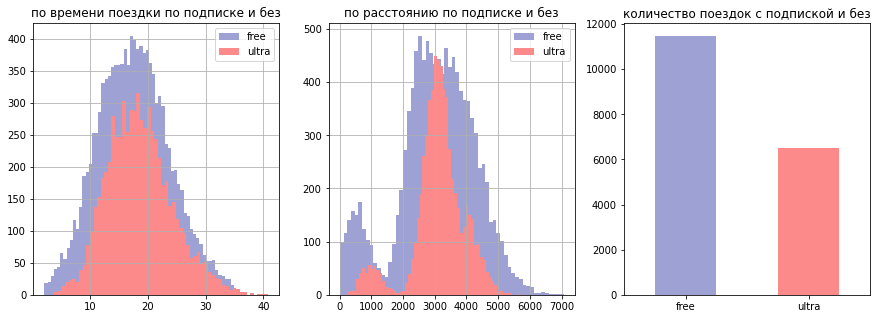

In [109]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5),gridspec_kw={'wspace': 0.2})
free_subs['duration'].hist( bins=60, label='free',ax=axs[0],color='#9EA1D4')
ultra_subs['duration'].hist( bins=60, label='ultra',ax=axs[0],color='#FD8A8A')
axs[0].legend()
axs[0].set_title('по времени поездки по подписке и без')
free_subs['distance'].hist( bins=60, label='free',ax=axs[1],color='#9EA1D4')
ultra_subs['distance'].hist( bins=60, label='ultra',ax=axs[1],color='#FD8A8A')
axs[1].legend()
axs[1].set_title('по расстоянию по подписке и без')
merged_data['subscription_type'].value_counts().plot(kind='bar',rot=0,ax=axs[2],color=['#9EA1D4', '#FD8A8A'])
axs[2].set_title('количество поездок с подпиской и без');

In [110]:
print('Процент поездок без подписки: ',
      round(free_subs.shape[0]/merged_data.shape[0] * 100),'%', sep='')
print('Процент поездок с подпиской: ',
      round(ultra_subs.shape[0]/merged_data.shape[0] * 100),'%', sep='')

Процент поездок без подписки: 64%
Процент поездок с подпиской: 36%


In [111]:
print('Процент пользователей с подпиской: ',
      round(users['subscription_type'].value_counts()['ultra']/users.shape[0] * 100),'%', sep='')
print('Процент пользователей без подписки: ',
      round(users['subscription_type'].value_counts()['free']/users.shape[0] * 100),'%', sep='')

Процент пользователей с подпиской: 46%
Процент пользователей без подписки: 54%


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Графики времени и расстояния довольно схожи по форме для пользоваателей с подпиской и без.
    Однако видно, что пользователи с подпиской совершают гораздо меньшее количество поездкок.
   

#### Шаг 5. Подсчёт выручки

Создадим новую табличку, хранящую выручку по месяцам

In [112]:
merged_data['duration'] = np.ceil(merged_data['duration'])
revenue = merged_data.pivot_table( 
                        index=['user_id','month'],
                        aggfunc={'distance': 'sum', 
                                 'duration': 'sum',
                                 'name':'count',
                                 'subscription_type':'first',
                                 'minute_price':'first',
                                 'start_ride_price':'first',
                                 'subscription_fee':'first'})
revenue.columns = ['distance','duration','minute_price','count','start_ride_price',
                   'subscription_fee','subscription_type']
revenue = revenue.reset_index()
# revenue['duration'] = np.ceil(revenue['duration'])
revenue.head()

,user_id,month,distance,duration,minute_price,count,start_ride_price,subscription_fee,subscription_type
0,1,1,7027.511294,42.0,6,2,0,199,ultra
1,1,4,754.159807,7.0,6,1,0,199,ultra
2,1,8,6723.470560,46.0,6,2,0,199,ultra
3,1,10,5809.911100,32.0,6,2,0,199,ultra
4,1,11,7003.499363,56.0,6,3,0,199,ultra


Считаем выручку

In [113]:
revenue['revenue'] = (
    revenue['start_ride_price'] * revenue['count'] 
    + revenue['minute_price'] * revenue['duration'] 
    + revenue['subscription_fee']
)
revenue.head()

,user_id,month,distance,duration,minute_price,count,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,7027.511294,42.0,6,2,0,199,ultra,451.0
1,1,4,754.159807,7.0,6,1,0,199,ultra,241.0
2,1,8,6723.470560,46.0,6,2,0,199,ultra,475.0
3,1,10,5809.911100,32.0,6,2,0,199,ultra,391.0
4,1,11,7003.499363,56.0,6,3,0,199,ultra,535.0


Создадим таблички с выручкой по подписчикам, это понадобиться на следующих шагах

In [114]:
ultra_revenue = revenue.query('subscription_type == "ultra"').reset_index(drop=True)
free_revenue = revenue.query('subscription_type == "free"').reset_index(drop=True)

In [115]:
display(ultra_revenue.head())
free_revenue.head()

,user_id,month,distance,duration,minute_price,count,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,7027.511294,42.0,6,2,0,199,ultra,451.0
1,1,4,754.159807,7.0,6,1,0,199,ultra,241.0
2,1,8,6723.470560,46.0,6,2,0,199,ultra,475.0
3,1,10,5809.911100,32.0,6,2,0,199,ultra,391.0
4,1,11,7003.499363,56.0,6,3,0,199,ultra,535.0


,user_id,month,distance,duration,minute_price,count,start_ride_price,subscription_fee,subscription_type,revenue
0,700,1,2515.690719,15.0,8,1,50,0,free,170.0
1,700,2,13446.659764,89.0,8,5,50,0,free,962.0
2,700,3,3798.334905,19.0,8,1,50,0,free,202.0
3,700,4,2984.551206,16.0,8,1,50,0,free,178.0
4,700,6,5927.650988,29.0,8,2,50,0,free,332.0


#### Шаг 6. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза:

- среднее время поездки для пользователей с подпиской и без равно

Альтернативная гипотеза:

- среднее время поездки для пользователей с подпиской больше чем у пользователей без подписки

Посмотрим на стандартное отклонение и дисперсию

In [117]:
print(ultra_subs['duration'].std())
free_subs['duration'].std()

5.572048329261366


6.162608726726466

In [118]:
print(np.var(ultra_subs['duration'], ddof=1))
np.var(free_subs['duration'], ddof=1)

31.047722583624388


37.977746318725195

Стандартные отклонения и дисперсии различаются, учтем это при проверке гипотезы

In [119]:
alpha = .05

result = st.ttest_ind(
    ultra_subs['duration'], 
    free_subs['duration'], 
    equal_var=False,
    alternative='greater')
    
print('p-значение:', result.pvalue)
    
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: среднее время поездки для пользователей с подпиской и без равно")
else:
    print("Не отвергаем нулевую гипотезу: среднее время поездки для пользователей с подпиской больше чем у пользователей без подписки")

p-значение: 1.6162210195311063e-29
Отвергаем нулевую гипотезу: среднее время поездки для пользователей с подпиской и без равно


In [120]:
print('Среднее время поездки ultra: ',ultra_subs['duration'].mean())
print('Среднее время поездки free: ',free_subs['duration'].mean())

Среднее время поездки ultra:  18.54198516280583
Среднее время поездки free:  17.530771268800226


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Основываясь на полученных результатах, можно отвергнуть нулевую гипотезу, среднее время поездки для пользователей с подпиской и без - равно. 
    Так как тест был односторонний, то можно сказать, что среднее время поездки пользователей с подпиской больше

___

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза:

- среднее расстояние поездки пользователей с подпиской - 3130м

Альтернативная гипотеза:

- среднее расстояние поездки пользователей с подпиской превышает 3130м

In [121]:
test_m = 3130 

result = st.ttest_1samp(ultra_subs['distance'], test_m, alternative='greater')

alpha = 0.05  
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: среднее расстояние поездок пользователей с подпиской больше", test_m)
else:
    print("Не отвергаем нулевую гипотезу: нет достаточных доказательств,\
что среднее расстояние поездок пользователей с подпиской больше", 
          test_m)

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу: нет достаточных доказательств,что среднее расстояние поездок пользователей с подпиской больше 3130


In [122]:
print('Среднее расстояние поездки ultra: ',ultra_subs['distance'].mean())

Среднее расстояние поездки ultra:  3115.4453880370247


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Основываясь на полученных результатах, нельзя отвргнуть нулевую гипотезу. 
    То есть нельзя утверждать, что среднее расстояние поездки пользователей с подпиской меньше 3130 метров

___

 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Нулевая гипотеза:

- средняя выручка по месяцам от пользователей с подпиской равна выручке от пользователей без

Альтернативная гипотеза:

- средняя выручка по месяцам от пользователей с подпиской выше чем у пользователей без

Посмотрим на стандартное отклонение и дисперсию

In [123]:
print(ultra_revenue['revenue'].std())
free_revenue['revenue'].std()

88.26273694686297


183.2684188935208

Стандартные отклонения и дисперсии различаются, учтем это при проверке гипотезы

In [124]:
print(np.var(ultra_revenue['revenue'], ddof=1))
np.var(free_revenue['revenue'], ddof=1)

7790.31073335113


33587.31336373101

In [125]:
alpha = .05

result = st.ttest_ind(
    ultra_revenue['revenue'], 
    free_revenue['revenue'], 
    equal_var=False,
    alternative='greater')
    
print('p-значение:', result.pvalue)
    
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: средняя выручка по месяцам от пользователей с \
подпиской выше чем у пользователей без")
else:
    print("Не получилось отвергнуть нулевую гипотезу: нет достаточных доказательств,\
что средняя выручка по месяцам от пользователей с подпиской выше чем у пользователей без")

p-значение: 2.4970242872858465e-38
Отвергаем нулевую гипотезу: средняя выручка по месяцам от пользователей с подпиской выше чем у пользователей без


In [126]:
print('Средня выручка ultra: ',ultra_revenue['revenue'].mean())
print('Средня выручка free: ',free_revenue['revenue'].mean())

Средня выручка ultra:  362.7921906022502
Средня выручка free:  329.3326437121324


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Основываясь на полученных результатах, можно отвергнуть нулевую гипотезу.
    Так как тест был односторонний, то можно сказать, что средняя выручка по месяцам от пользователей с подпиской выше чем 
    у пользователей без

___

 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ:

Нулевая гипотеза:

- количество обращений **до** изменений и **после** - равно

Альтернативная гипотеза:

- количество обращений **после** изменений меньше, чем **до** изменений

Так как проверка гипотезы происходит на зависимых выборках (для конкретного пользователя есть данные о количестве обращений до обновления и после), понадобится односторонний тест для двух зависимых выборок:

`stats.ttest_rel(after, before, alternative='less')`

где:

`after` - выборка по пользователям после обновления

`before` - выборка по пользователям до обновлений

`alternative = 'less'` - альтернативная гипотеза говорит о том, что среднее по `after` меньше чем в `before`

#### Шаг 7. Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

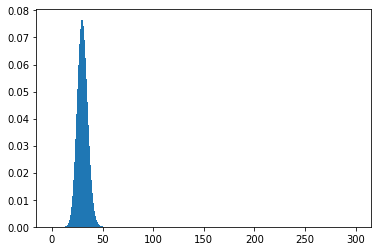

In [128]:
p = 1/10
n = 300
distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

Подберем количество нужное количество промокодов

In [129]:
p = 1/10
k = 100
for i in range(1,5000):
    cdf = binom.cdf(k, i, p)
    if cdf <= 0.05:
        print(cdf)
        print(i)
        break

0.04954795210203071
1172


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Для успешного проведения акции нужно разослать не меньше 1172 промокодов

___

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

проверим, подходит ли апроксимация нормальным распределением

In [130]:
p = 4/10
n = 10**6
mu = n * p
sigma = (n * p * (1 - p))**(0.5)
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Условие выполняется


In [131]:
distr = st.norm(mu, sigma) 
y_1 = 399500
result = distr.cdf(y_1)
print('Вероятность -',result)

Вероятность - 0.15371708296369768


Построим график

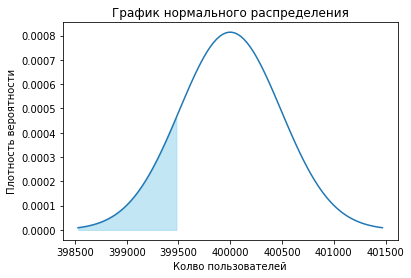

In [132]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2*sigma**2))
plt.plot(x, y)
plt.fill_between(x, y, where=(x <= y_1), color='skyblue', alpha=0.5)

plt.xlabel('Колво пользователей')
plt.ylabel('Плотность вероятности')
plt.title('График нормального распределения')

plt.show()

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
Вывод:
    
    Вероятность, что уведомления откроет не более 399,5тыс клиентов - 15%

#### Общий вывод

Были проанализированы данные о пользователях сервиса аренды самокатов.

Было сделано следующее:

- Предобработка данных: приведение типов, удаление пропусков, добавление столбца с месяцами, обработка аномалий

- Просмотрены разные параметры и получены выводы:
    - Количество пользователей в городах, где есть сервис примерно одинаково, однако по процентному соотношению по населению в городе на первом месте **Пятигорск**, а на последнем **Москва**
    - Пользователей с подпиской и без - 45.6% и 54.4% соответственно
    - Среднийий возраст пользователей - 25 лет. Процент пользователей возрастом 20-30 лет: 77%
    - Среднее растояние за поездку - 3060 м., однако есть небольшое увеличение количества поездкок длинной 0-1000 метров. Среднее не меняется от времени года или города
    - Среднее время за поездку - 18 мин. Среднее не меняется от времени года или города
    - Распределения по времени и расстоянии поездок у пользователей с подпиской и без схожи. Однако пользователи с подписки совершают гораздно меньше поездкок, чем пользователи без - 36% и 64% соответственно
- Были соданы дополнительные таблички, хранящие выручку с пользователей с подпиской и без
- Были проверены некоторые гипоезы
- Была проведена работа с биномиальным и нормальными распредлениями:
    - чтобы акция с рассылкй промокодов прошла успешно, нужно отправить не меньше 1172 промокодов
    - вероятность того, что из 1 млн пользователей уведомления открыли только 399.5 тыс - 15%
